In [36]:
from math import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ChebyshevInterpolationCoefficients(values):
    size = len(values)
    n = size - 1
    multiplier = 2. / n
    coefficients = [0.] * size
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        for j in range(size):
            coefficients[j] += multiplier * factor * values[i] * cos(pi * i * j / n)
            
    return coefficients

In [3]:
ChebyshevInterpolationCoefficients([1,2,3,4,6])

[6.25, -1.9571067811865472, 0.24999999999999956, -0.5428932188134523, 0.25]

In [4]:
def ChebyshevInterpolation(coefficients, z):
    size = len(coefficients)
    n = size - 1
    
    result = 0.
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        result += factor * coefficients[i] * cos(i * acos(z))
        
    return result

In [5]:
ChebyshevInterpolation(ChebyshevInterpolationCoefficients([1,2,3,4,6]),1)

1.0

In [30]:
def TestChebyshev(test_func, lower, upper):
    n = 15
    z = [0.] * n
    values = [0.] * n
    for i in range(n):
        z[i] = cos(pi * i / (n-1))
        values[i] = test_func(lower + (upper - lower) * .5 * (1. + z[i]))
      
    t = np.arange(lower, upper, 0.01)
    s1 = [test_func(x) for x in t]
    s2 = [ChebyshevInterpolation(ChebyshevInterpolationCoefficients(values), 
                                 2. * (x - lower) / (upper - lower) - 1.) for x in t]
    
    fig, ax = plt.subplots()
    ax.plot(t, s1)
    ax.plot(t, s2)
    plt.show()
      
    for i in range(n):
        diff = abs(values[i] - ChebyshevInterpolation(ChebyshevInterpolationCoefficients(values),z[i]))
        print(diff)

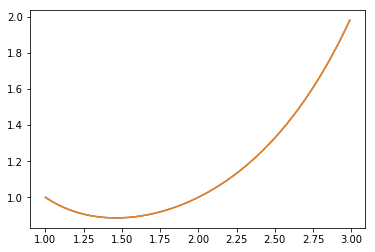

3.1086244689504383e-15
1.7763568394002505e-15
1.7763568394002505e-15
2.220446049250313e-16
1.1102230246251565e-15
4.440892098500626e-16
1.5543122344752192e-15
0.0
0.0
2.220446049250313e-16
3.3306690738754696e-16
2.3314683517128287e-15
3.552713678800501e-15
4.440892098500626e-16
1.5543122344752192e-15


In [40]:
test_func = lambda x : gamma(x)
TestChebyshev(test_func, 1., 3.)